# Simulating fleets of automated vehicles (AVs) making routing decisions: Bigger traffic network, IPPO algorithm implementation

> In this notebook, on the `Ingolstadt` network, we simulate **100 human agents** for `1700 days`. After 100 days **20 of the human agents** mutate into automated vehicles (AVs) and use the [`IPPO`](https://arxiv.org/pdf/2011.09533) (Independent Proximal Policy Optimization) algorithm implemented from the `TorchRL` library to learn the optimal route. The AVs are `selfish` and their goal is to maximize their own travel time. Since all AVs have their own reward signal, we model them using independent MARL algorithms. 

---

> The network used.
> 
![Network used](plots_saved/ingolstadt.png)

---

> Tutorial based on [Multi-Agent Reinforcement Learning (PPO) with TorchRL Tutorial](https://pytorch.org/rl/stable/tutorials/multiagent_ppo.html).

![Alt text](../../docs/img/env.png)


---


#### Imported libraries

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))

import torch
from tqdm import tqdm

from tensordict.nn import TensorDictModule
from torchrl.collectors import SyncDataCollector
from torch.distributions import Categorical
from torchrl.envs.libs.pettingzoo import PettingZooWrapper
from torchrl.envs.transforms import TransformedEnv, RewardSum
from torchrl.envs.utils import check_env_specs
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.modules import MultiAgentMLP, ProbabilisticActor
from torchrl.objectives.value import GAE
from torchrl.objectives import ClipPPOLoss, ValueEstimators

from routerl import TrafficEnvironment

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


#### Hyperparameters setting

In [2]:
# Devices
device = (
    torch.device(0)
    if torch.cuda.is_available()
    else torch.device("cpu")
)
print("device is: ", device)

# Sampling
frames_per_batch = 100  # Number of team frames collected per training iteration
n_iters = 300  # Number of sampling and training iterations - the episodes the plotter plots
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 1  # Number of optimization steps per training iteration
minibatch_size = 2  # Size of the mini-batches in each optimization step
lr = 3e-4 # Learning rate
max_grad_norm = 3.0  # Maximum norm for the gradients

# PPO
clip_epsilon = 0.2  # clip value for PPO loss
gamma = 0.99  # discount factor
lmbda = 0.9  # lambda for generalised advantage estimation
entropy_eps = 1e-4  # coefficient of the entropy term in the PPO loss


policy_network_depth=3
policy_network_num_cells = 64

critic_network_depth=3
critic_network_num_cells = 64

# Human learning phase
human_learning_episodes = 100
new_machines_after_mutation = 20

# number of episodes the AV training will take
training_episodes = (frames_per_batch / new_machines_after_mutation) * n_iters

env_params = {
    "agent_parameters" : {
        "num_agents" : 100,
        "new_machines_after_mutation": new_machines_after_mutation,
        "human_parameters" : {
            "model" : "w_avg"
        },
    },
    "simulator_parameters" : {
        "network_name" : "ingolstadt"
    },  
    "plotter_parameters" : {
        "phases" : [0, human_learning_episodes, training_episodes],
    },
    "path_generation_parameters":
    {
        "number_of_paths" : 5,
        "beta" : -2,
    }
}

device is:  cpu


#### Environment initialization

> In this example, the environment initially contains only human agents.

In [3]:
env = TrafficEnvironment(seed=42, **env_params)

[CONFIRMED] Environment variable exists: SUMO_HOME
[SUCCESS] Added module directory: C:\Program Files (x86)\Eclipse\Sumo\tools


> Available paths create using the [Janux](https://github.com/COeXISTENCE-PROJECT/JanuX) framework.

| |  |
|---------|---------|
|  ![](plots_saved/0_0.png) |  ![](plots_saved/0_1.png) |
| ![](plots_saved/1_0.png) | ![](plots_saved/1_1.png) |

In [4]:
print("Number of total agents is: ", len(env.all_agents), "\n")
print("Number of human agents is: ", len(env.human_agents), "\n")
print("Number of machine agents (autonomous vehicles) is: ", len(env.machine_agents), "\n")

Number of total agents is:  100 

Number of human agents is:  100 

Number of machine agents (autonomous vehicles) is:  0 



> Reset the environment and the connection with SUMO

In [5]:
env.start()
env.reset()

({}, {})

#### Human learning

In [6]:
for episode in range(human_learning_episodes):
    env.step()

#### Mutation

> **Mutation**: a portion of human agents are converted into machine agents (autonomous vehicles).

In [7]:
env.mutation()

In [8]:
print("Number of total agents is: ", len(env.all_agents), "\n")
print("Number of human agents is: ", len(env.human_agents), "\n")
print("Number of machine agents (autonomous vehicles) is: ", len(env.machine_agents), "\n")

Number of total agents is:  100 

Number of human agents is:  80 

Number of machine agents (autonomous vehicles) is:  20 



#### PettingZoo environment wrapper

> `TorchRL` enables us to make different groups with different agents. Here, all the AV agents are included in one group.

In [9]:
group = {'agents': [str(machine.id) for machine in env.machine_agents]}

env = PettingZooWrapper(
    env=env,
    use_mask=True,
    categorical_actions=True,
    done_on_any = False,
    group_map=group,
    device=device
)

#### Transforms

In [10]:
env = TransformedEnv(
    env,
    RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")]),
)

The <code style="color:white">check_env_specs()</code> function runs a small rollout and compared it output against the environment specs. It will raise an error if the specs aren't properly defined.

In [11]:
check_env_specs(env)


2025-02-12 20:41:39,056 [torchrl][INFO] check_env_specs succeeded!


In [12]:
reset_td = env.reset()

#### Policy/Actor network

In [13]:
share_parameters_policy = False 

policy_net = torch.nn.Sequential(
    MultiAgentMLP(
        n_agent_inputs = env.observation_spec["agents", "observation"].shape[-1],
        n_agent_outputs = env.action_spec.space.n,
        n_agents = env.n_agents,
        centralised=False,
        share_params=share_parameters_policy,
        device=device,
        depth=policy_network_depth,
        num_cells=policy_network_num_cells,
        activation_class=torch.nn.Tanh,
    ),
)

In [14]:
policy_module = TensorDictModule(
    policy_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "logits")],
) 

In [15]:
policy = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=[("agents", "logits")],
    out_keys=[env.action_key],
    distribution_class=Categorical,
    return_log_prob=True,
    log_prob_key=("agents", "sample_log_prob"),
)

#### Critic network

In [16]:
share_parameters_critic = True
mappo = False  # IPPO if False

critic_net = MultiAgentMLP(
    n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],
    n_agent_outputs=1, 
    n_agents=env.n_agents,
    centralised=mappo,
    share_params=share_parameters_critic,
    device=device,
    depth=critic_network_depth,
    num_cells=critic_network_num_cells,
    activation_class=torch.nn.ReLU,
)

critic = TensorDictModule(
    module=critic_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "state_value")],
)

In [17]:
print("Running policy:", policy(env.reset()))

Running policy: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([20]), device=cpu, dtype=torch.int64, is_shared=False),
                done: Tensor(shape=torch.Size([20, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([20, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                logits: Tensor(shape=torch.Size([20, 5]), device=cpu, dtype=torch.float32, is_shared=False),
                mask: Tensor(shape=torch.Size([20]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([20, 6]), device=cpu, dtype=torch.float32, is_shared=False),
                sample_log_prob: Tensor(shape=torch.Size([20]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([20, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(sh

In [18]:
print("Running value:", critic(env.reset()))

Running value: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([20, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([20, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                mask: Tensor(shape=torch.Size([20]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([20, 6]), device=cpu, dtype=torch.float32, is_shared=False),
                state_value: Tensor(shape=torch.Size([20, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([20, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([20, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([20]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([1]), de

#### Collector

In [19]:
collector = SyncDataCollector(
    env,
    policy,
    device=device,
    storing_device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
) 

#### Replay buffer

In [20]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(
        frames_per_batch, device=device
    ),  
    sampler=SamplerWithoutReplacement(),
    batch_size=minibatch_size,
)

#### PPO loss function

In [21]:
loss_module = ClipPPOLoss(
    actor_network=policy,
    critic_network=critic,
    clip_epsilon=clip_epsilon,
    entropy_coef=entropy_eps,
    normalize_advantage=False,
)
loss_module.set_keys( 
    reward=env.reward_key,  
    action=env.action_key, 
    sample_log_prob=("agents", "sample_log_prob"),
    value=("agents", "state_value"),
    done=("agents", "done"),
    terminated=("agents", "terminated"),
)

loss_module.make_value_estimator(
    ValueEstimators.GAE, gamma=gamma, lmbda=lmbda
) 

GAE = loss_module.value_estimator

optim = torch.optim.Adam(loss_module.parameters(), lr)

#### Training loop

In [ ]:
pbar = tqdm(total=n_iters, desc="episode_reward_mean = 0")

episode_reward_mean_list = []
loss_values = []
loss_entropy = []
loss_objective = []
loss_critic = []

for tensordict_data in collector: ##loops over frame_per_batch

    ## Generate the rollouts
    tensordict_data.set(
        ("next", "agents", "done"),
        tensordict_data.get(("next", "done"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),  # Adjust index to start from 0
    )
    tensordict_data.set(
        ("next", "agents", "terminated"),
        tensordict_data.get(("next", "terminated"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),  # Adjust index to start from 0
    )

    # Compute GAE for all agents
    with torch.no_grad():
            GAE(
                tensordict_data,
                params=loss_module.critic_network_params,
                target_params=loss_module.target_critic_network_params,
            )

    data_view = tensordict_data.reshape(-1)  
    replay_buffer.extend(data_view)

    ## Update the policies of the learning agents
    for _ in range(num_epochs):
        for _ in range(frames_per_batch // minibatch_size):
            subdata = replay_buffer.sample()
            loss_vals = loss_module(subdata)

            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            loss_value.backward()

            torch.nn.utils.clip_grad_norm_(
                loss_module.parameters(), max_grad_norm
            ) 

            optim.step()
            optim.zero_grad()

            loss_values.append(loss_value.item())

            loss_entropy.append(loss_vals["loss_entropy"].item())

            loss_objective.append(loss_vals["loss_objective"].item())

            loss_critic.append(loss_vals["loss_critic"].item())


   
    collector.update_policy_weights_()
   
    # Logging
    done = tensordict_data.get(("next", "agents", "done"))  # Get done status for the group

    episode_reward_mean = (
        tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
    )
    episode_reward_mean_list.append(episode_reward_mean)


    pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=False)
    pbar.update()

episode_reward_mean = -10.355666160583496:   1%|▏         | 4/300 [01:14<1:32:22, 18.72s/it]

> Testing phase

In [ ]:
policy.eval() # set the policy into evaluation mode

num_episodes = 100
for episode in range(num_episodes):
    env.rollout(len(env.machine_agents), policy=policy)

> Plots of the training process are include in the **\plots** folder.

IndexError: list index out of range

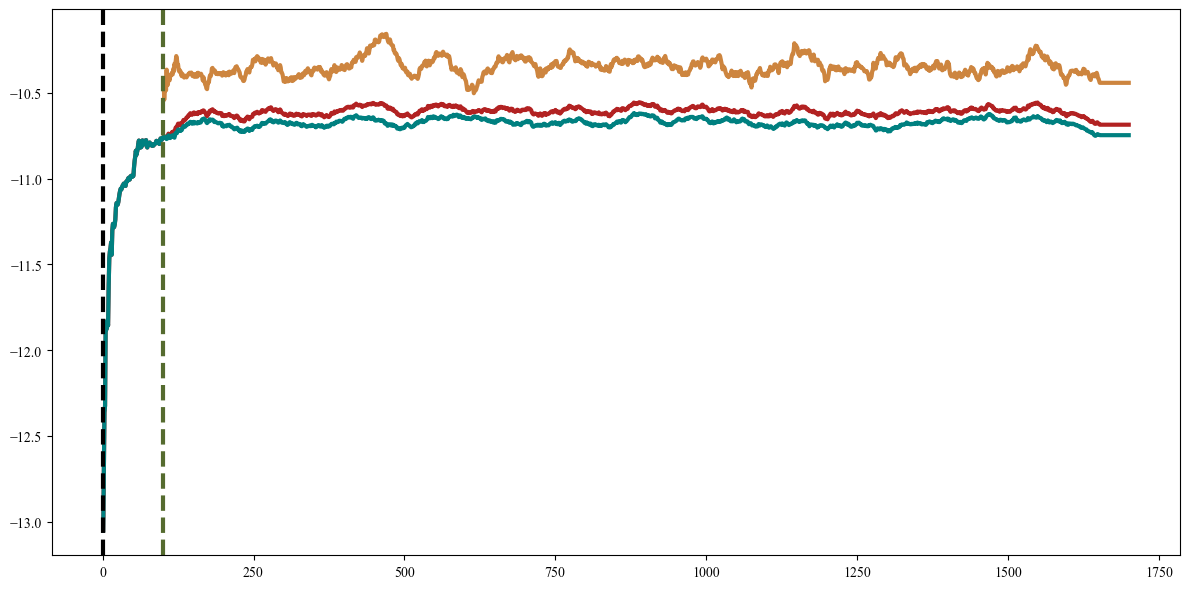

In [ ]:
env.plot_results()

> The plots reveal that the introduction of AVs into urban traffic influences human agents' decision-making. This insight highlights the need for research aimed at mitigating potential negative effects of AV introduction, such as increased human travel times, congestion, and subsequent rises in $CO_2$ emissions.

| |  |
|---------|---------|
| **Action shifts of human and AV agents** ![](plots_saved/ippo_actions_shifts.png) | **Action shifts of all vehicles in the network** ![](plots_saved/ippo_actions.png) |
| ![](plots_saved/ippo_rewards.png) | ![](plots_saved/ippo_travel_times.png) |


<p align="center">
  <img src="plots_saved/ippo_tt_dist.png" width="700" />
</p>


> Interrupt the connection with `SUMO`.

In [ ]:
env.stop_simulation()